In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras



#2.14.0 or later
print(tf.__version__)


2.14.0


#### Load Dataset

In [2]:
def preprocess_data( X, y):

    X = X.reshape(X.shape[0], 32, 32, 3)
    X = X.astype("float32")
    X = X/255.

    y = tf.keras.utils.to_categorical(y, 10)
    return X, y

In [3]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)


In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

bird
(32, 32, 3)


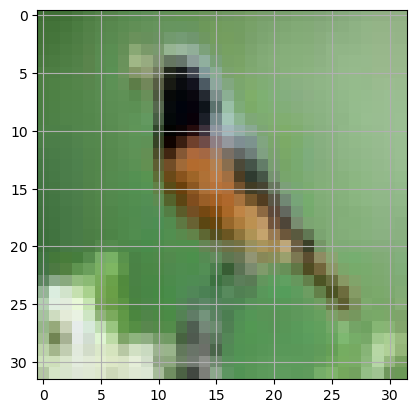

In [5]:
image_id = 75 # Image index in the test set

print(class_names[np.argmax(y_test[image_id])])


plt.grid()
print(x_test[image_id].shape)
plt.imshow(x_test[image_id])
plt.show()

In [6]:
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])
        #print(xs.shape)
        #print(xs)
    # Copy the image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    #print("tile : ",(tile))
    #print("imgs : ",imgs.shape)
    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)

        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos = int(pixel[0]),int(pixel[1])
            rgb = (pixel[2],pixel[3],pixel[4])
            img[x_pos, y_pos] = rgb
    return imgs

In [7]:
pixel = np.array([16, 16, 255, 255, 0])
result = perturb_image(pixel, x_test[image_id])
print(result.shape)

(1, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


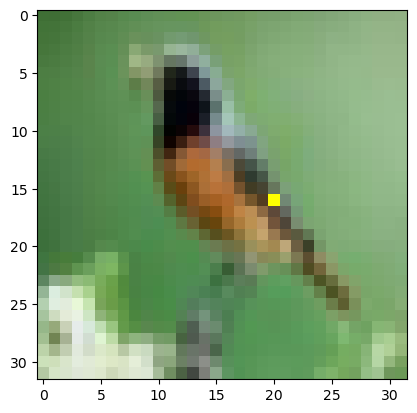

In [8]:
image_id = 75 
pixel = np.array([16, 20,100, 255, 0]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel, x_test[image_id])[0]
plt.imshow(image_perturbed)

### tf and check GPU backend

In [9]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-07-11 16:38:19.155547: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-07-11 16:38:19.155576: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-07-11 16:38:19.155582: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-07-11 16:38:19.155623: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-11 16:38:19.155643: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


True

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,MaxPool2D,Dropout, BatchNormalization

input_shape = (32,32,3)
model = tf.keras.models.Sequential([
    Conv2D(32,kernel_size=(3,3),activation = 'relu', padding = 'same',input_shape = input_shape),
    BatchNormalization(),
    Conv2D(32,kernel_size=(3,3),activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPool2D(pool_size = (2,2)),
   
    
    Conv2D(64,kernel_size=(3,3),activation = 'relu', padding = 'same'),
    BatchNormalization(),
    Conv2D(64,kernel_size=(3,3),activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPool2D(pool_size = (2,2)),

    Flatten(),
    Dense(128,activation = 'relu'),
    Dense(128,activation = 'relu'),
    Dropout(0.5),

    Dense(10, activation='softmax')]

)


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

In [45]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
opt = SGD(learning_rate=0.001, momentum=0.9)
#model.compile(optimizer=opt,loss=loss_fn, metrics=["accuracy"])

model.compile(optimizer=Adam(lr=0.001), loss=loss_fn, metrics=["accuracy"])

import time
start_time = time.time()
history = model.fit(x_train, y_train, epochs=40,
           validation_data = (x_test,y_test), batch_size=128)
print(time.time()- start_time)

Epoch 1/40


/opt/anaconda3/envs/ths/lib/python3.10/site-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-07-11 16:12:29.712394: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


 58/391 [===>..........................] - ETA: 6s - loss: 10.8621 - accuracy: 0.1937

KeyboardInterrupt: 

In [ ]:
model.save("cifar10_model.h5")

/opt/anaconda3/envs/ths/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
model = tf.keras.models.load_model("resnet.h5")
model.summary()

2024-07-11 16:38:27.417192: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-11 16:38:27.417214: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 16)           448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 32, 32, 16)           64        ['conv2d_1[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_1 (Activation)   (None, 32, 32, 16)           0         ['batch_normalization_1[

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

NameError: name 'history' is not defined

2024-07-11 16:38:31.234345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 819ms/step
Predicted label :  ship
Confidence :  0.99999964


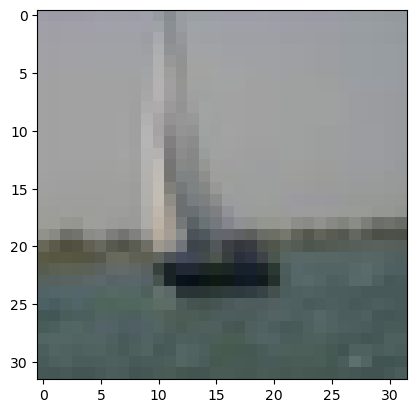

In [12]:
image_id = 55
pixel = np.array([16, 13,  25, 48, 156]) 

test_img = x_test[image_id]
reshaped_img = np.array([test_img])

true_class = y_test[image_id, 0]


prior_confidence = model.predict(reshaped_img,batch_size =1)[0]
result_index = (np.argmax(prior_confidence))
print("Predicted label : ",class_names[result_index])
print("Confidence : ",prior_confidence[result_index])
plt.imshow(test_img)

#### Sample Attack


In [13]:
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    print("x : ",x)
    attack_image = perturb_image(x, img)


    #reshaped_img = np.array([attack_image])

    predicted_result = model.predict(attack_image,batch_size =1)[0]
    predicted_class_index = (np.argmax(predicted_result))

    confidence =predicted_result[predicted_class_index]

    
    # If the prediction is what we want (misclassification or 
    # targeted classification), return True
    if verbose:
        print('Confidence:', confidence)
        print("Class : ",class_names[predicted_class_index])
    if ((targeted_attack and predicted_class_index == target_class) or
        (not targeted_attack and predicted_class_index != target_class)):
        
        return True
    # NOTE: return None otherwise (not False), due to how Scipy handles its callback function

In [14]:
def predict_classes(xs, img, target_class, model, minimize=True):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    #print("xs : ",xs.shape)
    imgs_perturbed = perturb_image(xs, img)
    predictions = model.predict(imgs_perturbed,batch_size =1)[0]

    pred_index =(np.argmax(predictions))
    predictions = predictions[pred_index]
    
    # This function should always be minimized, so return its complement if needed
    return predictions if minimize else 1 - predictions

1/1 [==============================] - 0s 41ms/step
Confidence in true class bird is 0.7089785
1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prior confidence :  0.93442166
Prior class :  frog


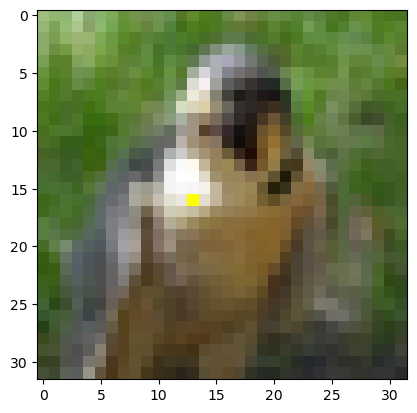

In [15]:
image_id = 384
pixel = np.array([16, 13,  255, 255, 0])

true_class = np.argmax(y_test[image_id])
confidence = predict_classes(pixel, x_test[image_id], true_class, model)
print('Confidence in true class', class_names[true_class], 'is', confidence)





test_img = x_test[image_id]
reshaped_img = np.array([test_img])
predicted_result = model.predict(reshaped_img,batch_size =1)[0]
predicted_class = (np.argmax(predicted_result))
print('Prior confidence : ', predicted_result[predicted_class])
print("Prior class : ",class_names[predicted_class])


attack_image = perturb_image(pixel, test_img)

plt.imshow(attack_image[0])


In [17]:
image_id = 75
pixel = np.array([17, 17, 150, 255, 50])


true_class = np.argmax(y_test[image_id])



test_img = x_test[image_id]
reshaped_img = np.array([test_img])
predicted_result = model.predict(reshaped_img,batch_size =1)[0]
predicted_class = (np.argmax(predicted_result))


print("True class : ", class_names[true_class])
print('Prior confidence : ', predicted_result[predicted_class])
print("Prior class : ",class_names[predicted_class])

confidence =predicted_result[predicted_class]
success = attack_success(pixel, x_test[image_id], true_class, model, verbose=True)
if success:
    plt.imshow(perturb_image(pixel, test_img)[0])


1/1 [==============================] - 0s 16ms/step
True class :  bird
Prior confidence :  1.0
Prior class :  bird
x :  [ 17  17 150 255  50]
1/1 [==============================] - 0s 13ms/step
Confidence: 0.9999025
Class :  bird


In [18]:
from scipy.optimize import differential_evolution

In [19]:
def attack(img_id, model, target=None, pixel_count=1, 
           maxiter=75, popsize=400, verbose=False):
    # Change the target class based on whether this is a targeted attack or not
    targeted_attack = target is not None
    target_class = target if targeted_attack else np.argmax(y_test[img_id])


    print("target_class : ",target_class)
    # Define bounds for a flat vector of x,y,r,g,b values
    # For more pixels, repeat this layout
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count

    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    
    # Format the predict/callback functions for the differential evolution algorithm
    def predict_fn(xs):
        return predict_classes(xs, x_test[img_id], target_class, 
                               model, target is None)
    

    def callback_fn(x, convergence):
        return attack_success(x, x_test[img_id], target_class, 
                              model, targeted_attack, verbose)
    


     # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
    predict_fn, bounds, maxiter=maxiter, popsize=popmul,
    recombination=1, atol=-1, callback=callback_fn, polish=False)


    
  
     # Calculate some useful statistics to return from this function
    attack_image = perturb_image(attack_result.x, x_test[img_id])[0]

    

 
    original_img = np.array(x_test[img_id])
    

    #print("attack image : ",attack_image.shape)
    prior_probs = model.predict(reshaped_img,batch_size =1)[0]

    attack_image =  np.array([attack_image])
    #attack_image =c 
    predicted_probs = model.predict(attack_image,batch_size =1)[0]
    #print("predicted_probs : ",predicted_probs)

    predicted_class = np.argmax(predicted_probs)
    actual_class = np.argmax(y_test[img_id])

    

    success = predicted_class != actual_class
    #print("Success status : ",success)
    
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    return [model.name, pixel_count, img_id, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_result.x]



1/1 [==============================] - 0s 16ms/step
Actual class :  horse
Prior confidence :  1.0


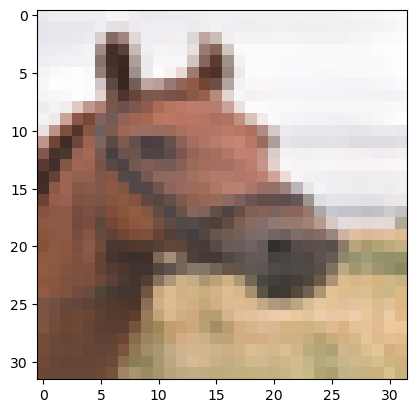

In [27]:
image_id = 99
pixels = 1 # Number of pixels to attack

reshaped_img = np.array([test_img])
predicted_result = model.predict(reshaped_img,batch_size =1)[0]
predicted_class = (np.argmax(predicted_result))
print("Actual class : ",class_names[np.argmax(y_test[image_id])])
print('Prior confidence : ', predicted_result[predicted_class])

plt.imshow(x_test[image_id])

In [29]:

attack_result = attack(image_id, model, pixel_count=pixels, verbose=True)


target_class :  7
1/1 [==============================] - 0s 13ms/step
x :  [  3.78916343  18.42221645 203.28966623   9.35797448 169.88795154]
1/1 [==============================] - 0s 12ms/step
Confidence: 0.33884463
Class :  bird
1/1 [==============================] - 0s 12ms/step


In [30]:
model_name, pixel_count, img_id, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_result_x = attack_result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prior_probs :  8.899628e-13
predicted_probs :  0.00014524574


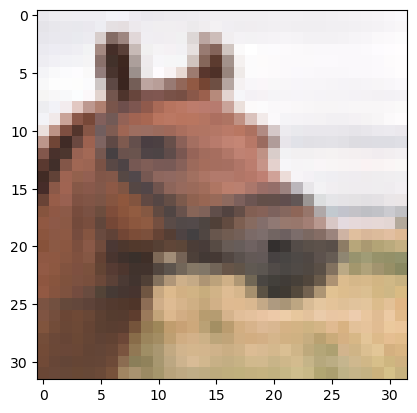

In [34]:
print("prior_probs : ",prior_probs[actual_class])
print("predicted_probs : ",predicted_probs[actual_class])
pixel = attack_result_x
image_perturbed = perturb_image(pixel, x_test[image_id])[0]
plt.imshow(image_perturbed)